In [1]:
# Import the libraries we need for this lab

# Using the following line code to install the torchvision library
# !conda install -y torchvision

# PyTorch Library
import torch 
# PyTorch Neural Network
import torch.nn as nn
# Allows us to transform data
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
import torch.nn.functional as F

# Creating graphs
import matplotlib.pylab as plt
# Allows us to use arrays to manipulate and store data
import numpy as np
#from sklearn.metrics import confusion_matrix

In [2]:
def PlotParameters(model): 
    # Get the weights of the first layer if using ResNet18, or modify appropriately for your model
    if hasattr(model, 'fc2'):  # Check if model has a fully connected layer 'fc'
        W = model.fc2.weight.data.cpu().numpy()
    else:
        # Modify as needed for your model. For example:
        W = model.state_dict()[f'{layer_name}.weight'].cpu().numpy()

    w_min = W.min().item()
    w_max = W.max().item()
    normalized_weights = (W - w_min) / (w_max - w_min)

    # Check the shape of weights
    print(f"Weights shape: {normalized_weights.shape}")

    # Adjust figure size and number of subplots based on number of classes
    num_classes = W.shape[0]
    #fig, axes = plt.subplots(2, 2, figsize=(10, 5))
    #fig.subplots_adjust(hspace=0.3, wspace=0.3)

    # Plot heatmap for each class
    fig, axes = plt.subplots(1, num_classes, figsize=(10, 5))
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    for i in range(num_classes):
        ax = axes[i]
        if normalized_weights[i].size == 1024:
            heatmap = normalized_weights[i].reshape(32, 32)  # Adjust this reshape as needed
        else:
            heatmap = normalized_weights[i]  # Plot directly if it doesn't require reshaping
        ax.imshow(heatmap, cmap='seismic', interpolation='nearest')
        ax.set_title(f'Class => {dataset.classes[i]}')
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()
"""
    for i, ax in enumerate(axes.flat):
        if i < num_classes:
            
            # Set the label for the sub-plot.
            ax.set_xlabel("Class: {0}".format(i))
            weight_image = W[i].cpu().mean(dim=0)
            # Plot the weight as an image.
            # Assuming the weights correspond to a 128x128 grayscale image
            ax.imshow(weight_image, vmin=w_min, vmax=w_max, cmap='seismic')

            ax.set_xticks([])
            ax.set_yticks([])

    plt.show()
"""

'\n    for i, ax in enumerate(axes.flat):\n        if i < num_classes:\n            \n            # Set the label for the sub-plot.\n            ax.set_xlabel("Class: {0}".format(i))\n            weight_image = W[i].cpu().mean(dim=0)\n            # Plot the weight as an image.\n            # Assuming the weights correspond to a 128x128 grayscale image\n            ax.imshow(weight_image, vmin=w_min, vmax=w_max, cmap=\'seismic\')\n\n            ax.set_xticks([])\n            ax.set_yticks([])\n\n    plt.show()\n'

In [3]:
# Plot the data

def show_data(data_sample):
    plt.imshow(data_sample[0].numpy().reshape(128, 128), cmap='gray')
    plt.title(f"Actual = {dataset.classes[data_sample[1]]}")

In [4]:
# Step 1: Load and Preprocess the Dataset

# Define the data transformation
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images to 128x128 pixels
    transforms.Grayscale(),  # Convert images to grayscale
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize grayscale images
])

In [5]:
# Load the dataset
data_dir = 'faces_expression'  # Update this path to your dataset's location
dataset = datasets.ImageFolder(root=data_dir, transform=transform)


# Split dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

First Image and Label None


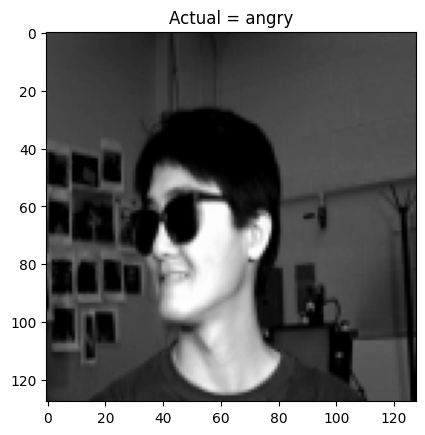

In [6]:
# Print the first image and label

print("First Image and Label", show_data(train_dataset[0]))

In [7]:
# Step 2: Define the Neural Network (Simple CNN)
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2,padding=0)
        self.fc1 = nn.Linear(128*16*16, 1024)
        self.fc2 = nn.Linear(1024, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.25)
        # Softmax layer
        self.softmax = nn.Softmax(dim=1)
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, kernel_size=2, stride=2)  # Apply max pooling
        # Second convolutional layer
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, kernel_size=2, stride=2)  # Apply max pooling
        # Third convolutional layer
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, kernel_size=2, stride=2)  # Apply max pooling
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        # Apply softmax to get the probabilities
        x = self.softmax(x)
        return x

In [8]:
# Example usage
num_classes=4
model = SimpleCNN(num_classes)  # 4 classes: angry, happy, neutral, sad

# Print the model architecture
print(model)

SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=32768, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=4, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.25, inplace=False)
  (softmax): Softmax(dim=1)
)


In [9]:
# Print the parameters

print('W: ',list(model.parameters())[0].size())
print('b: ',list(model.parameters())[1].size())

W:  torch.Size([32, 1, 3, 3])
b:  torch.Size([32])


Weights shape: (4, 1024)


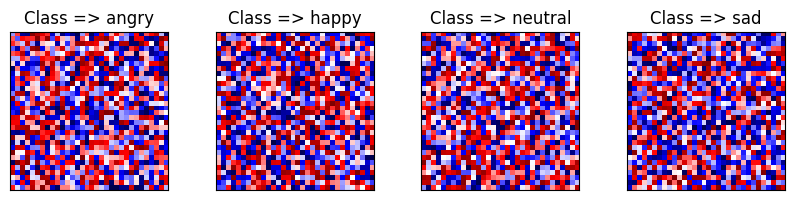

In [10]:
# Plot the model parameters for each class
PlotParameters(model)

In [11]:
criterion = nn.CrossEntropyLoss()  # Loss function for multi-class classification
optimizer = optim.SGD(model.parameters(), lr=0.001)  # Optimizer

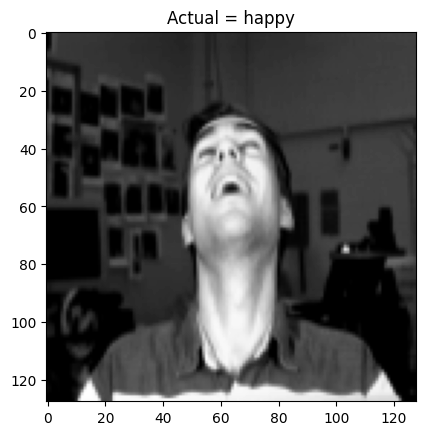

In [12]:
show_data(train_dataset[1])

In [13]:
# Created a training data loader so we can set the batch size
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=4)
# Created a validation data loader so we can set the batch size
validation_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=4)

True Label: 0
Predicted Class: 0


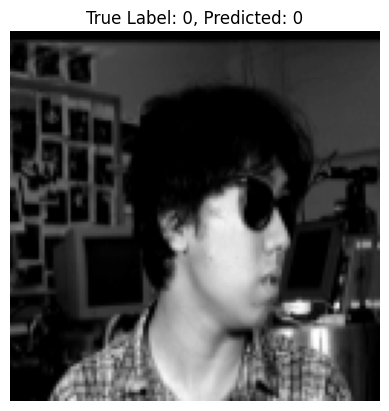

In [16]:
data, true_label = dataset[1] 
output = model(data.unsqueeze(0))
# Convert the output to probabilities using softmax
probabilities = nn.Softmax(dim=1)(output)
# Get the predicted class
_, predicted_class = torch.max(probabilities, 1)
print(f'True Label: {true_label}')
print(f'Predicted Class: {predicted_class.item()}')

# Optionally, visualize the input image
plt.imshow(data.cpu().squeeze().numpy(), cmap='gray')
plt.title(f'True Label: {true_label}, Predicted: {predicted_class.item()}')
plt.axis('off')
plt.show()

In [17]:
actual = torch.tensor([train_dataset[1][1]])
criterion(output, actual)

tensor(1.4012, grad_fn=<NllLossBackward0>)

In [18]:
softmax = nn.Softmax(dim=1)
probability = softmax(output)
print(probability)

tensor([[0.2699, 0.2463, 0.2548, 0.2290]], grad_fn=<SoftmaxBackward0>)


In [19]:
-1*torch.log(probability[0][actual])

tensor([1.4012], grad_fn=<MulBackward0>)

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
n_epochs = 20
loss_list = []
accuracy_list = []
N_test = len(val_dataset)

def train_model(n_epochs):
    for epoch in range(n_epochs):

        model.train() 
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            outputs = model(x)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
        
        correct = 0
        model.eval()
        for x_test, y_test in validation_loader:
            outputs = model(x_test)
            _, yhat = torch.max(outputs.data, 1)
            correct += (yhat == y_test).sum().item()
        accuracy = correct / N_test
        loss_list.append(loss.data)
        accuracy_list.append(accuracy)

In [23]:
# Function call
train_model(n_epochs)

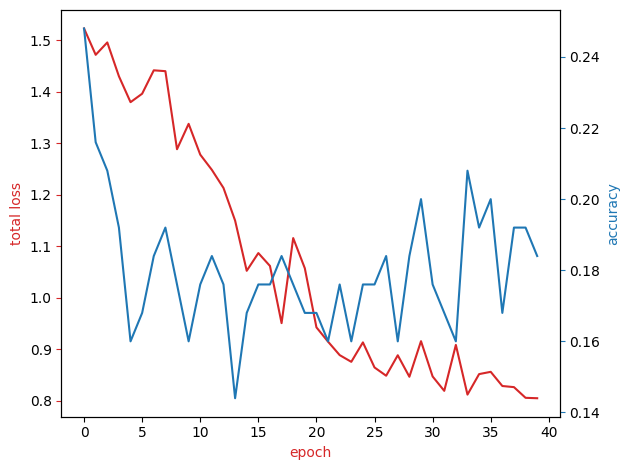

In [24]:
# Plot the loss and accuracy

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(loss_list,color=color)
ax1.set_xlabel('epoch',color=color)
ax1.set_ylabel('total loss',color=color)
ax1.tick_params(axis='y', color=color)
    
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color)  
ax2.plot( accuracy_list, color=color)
ax2.tick_params(axis='y', color=color)
fig.tight_layout()

Weights shape: (4, 1024)


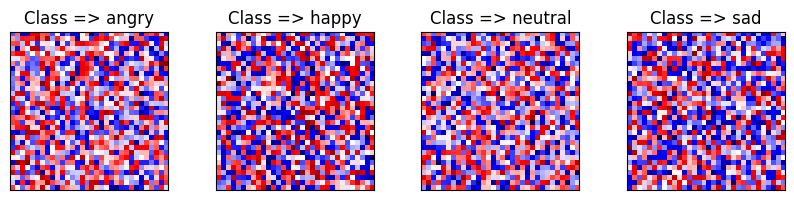

In [25]:
PlotParameters(model)

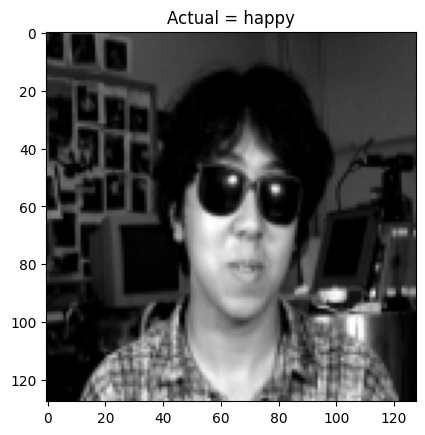

yhat: happy
probability of class  0.30764177441596985


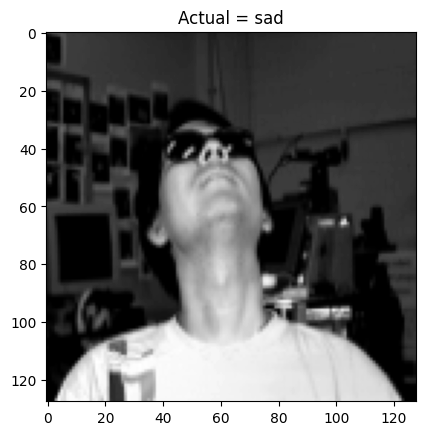

yhat: sad
probability of class  0.3644179105758667


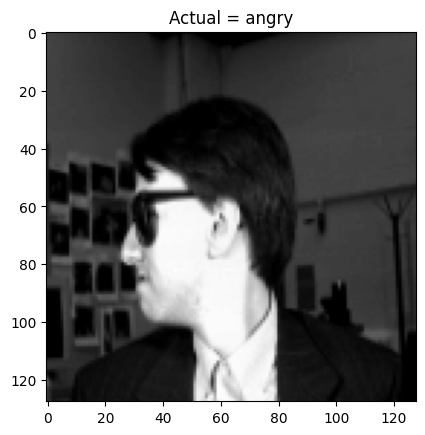

yhat: angry
probability of class  0.3270820677280426


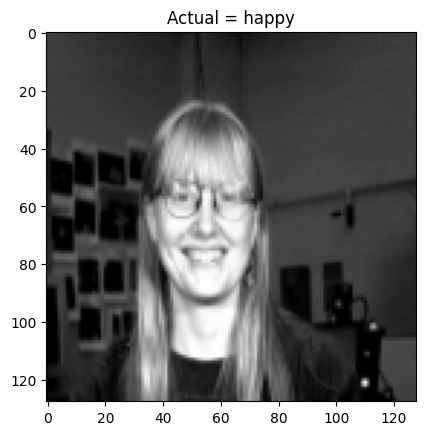

yhat: happy
probability of class  0.3124459683895111


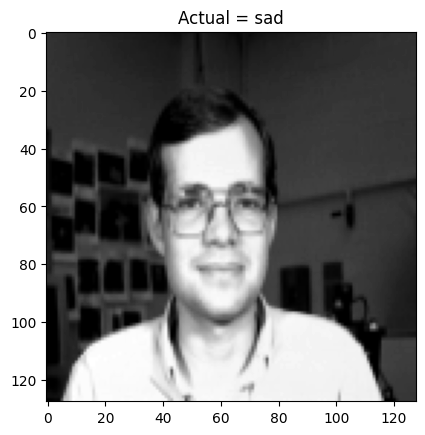

yhat: sad
probability of class  0.3005658686161041


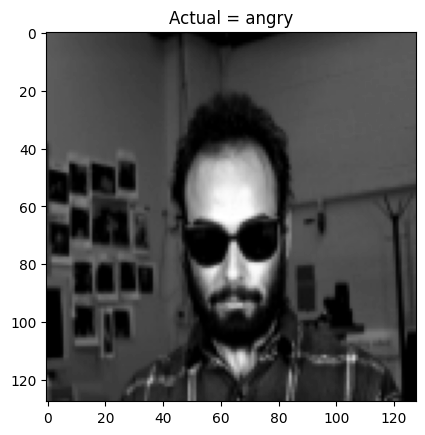

yhat: angry
probability of class  0.4617096483707428


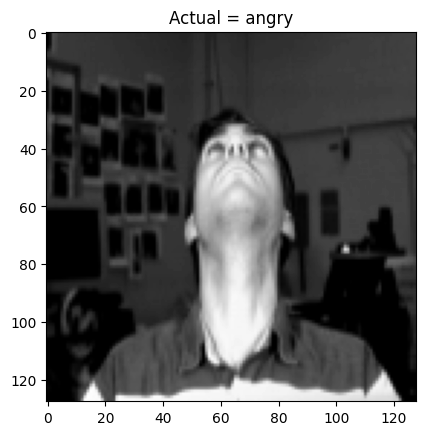

yhat: angry
probability of class  0.4534088671207428


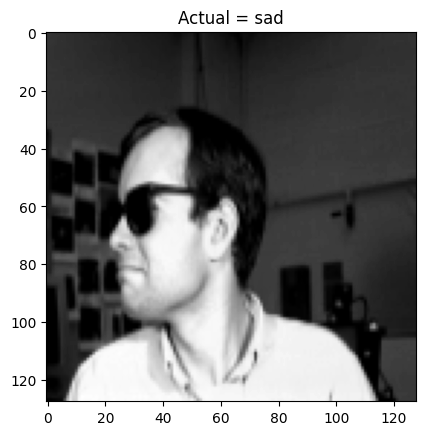

yhat: sad
probability of class  0.3283747434616089


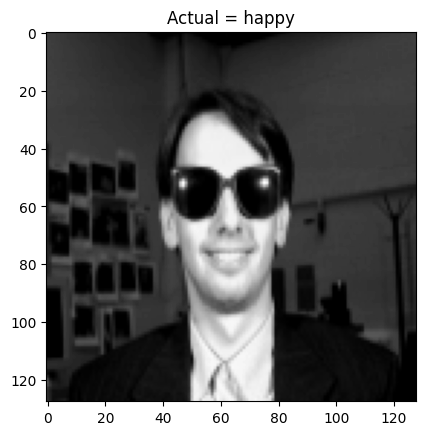

yhat: happy
probability of class  0.36873844265937805


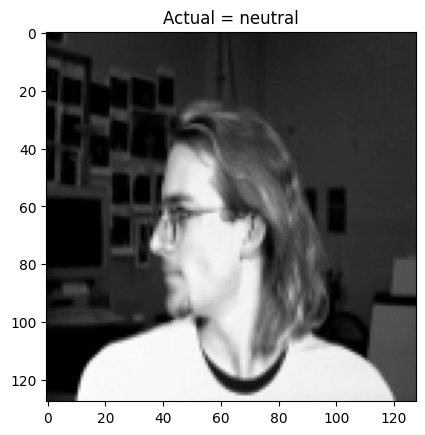

yhat: neutral
probability of class  0.4225083291530609


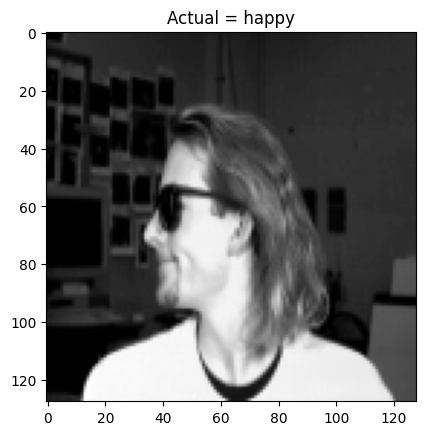

yhat: happy
probability of class  0.31735244393348694


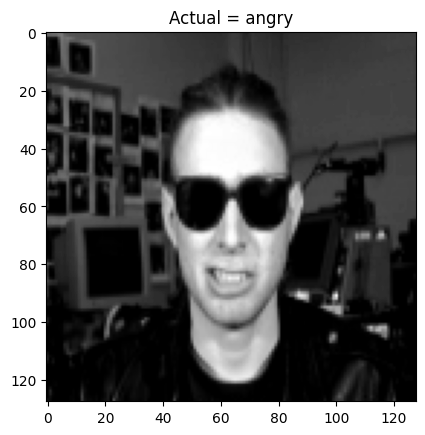

yhat: angry
probability of class  0.28654903173446655


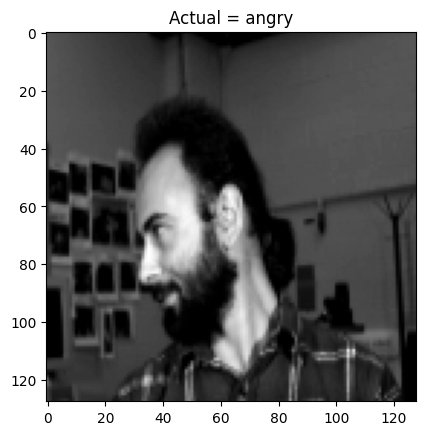

yhat: angry
probability of class  0.320313423871994


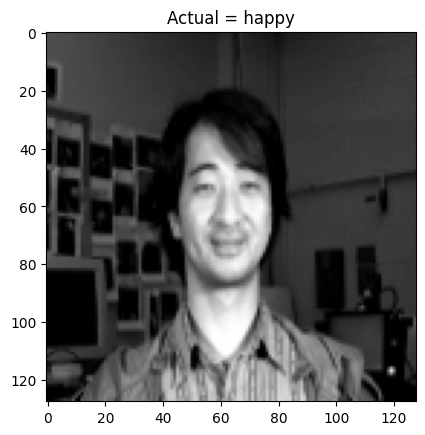

yhat: happy
probability of class  0.39407461881637573


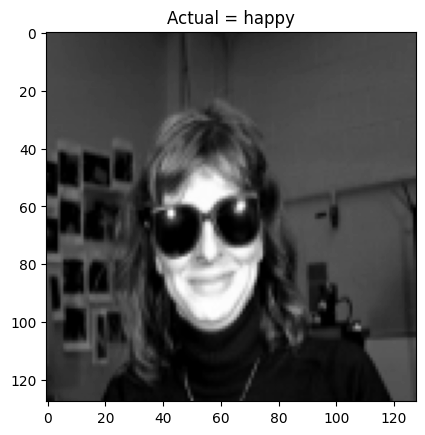

yhat: happy
probability of class  0.4652566909790039


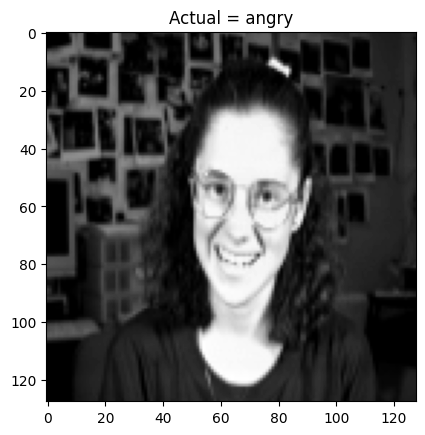

yhat: angry
probability of class  0.4279964566230774


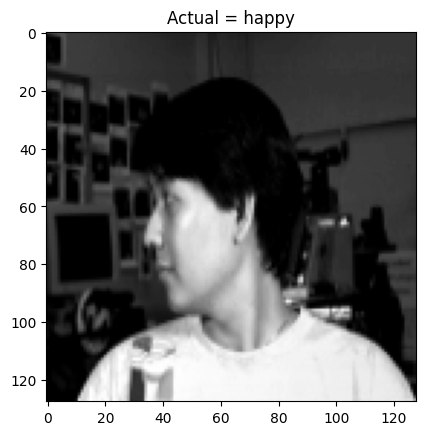

yhat: happy
probability of class  0.31368160247802734


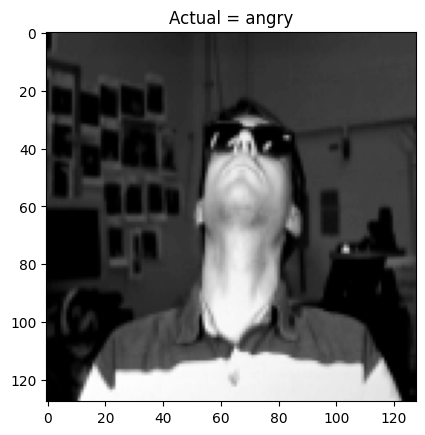

yhat: angry
probability of class  0.43804681301116943


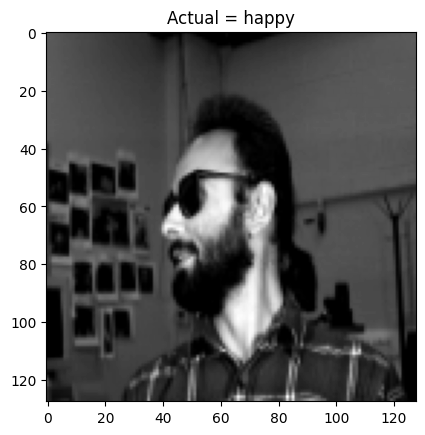

yhat: happy
probability of class  0.4297107458114624


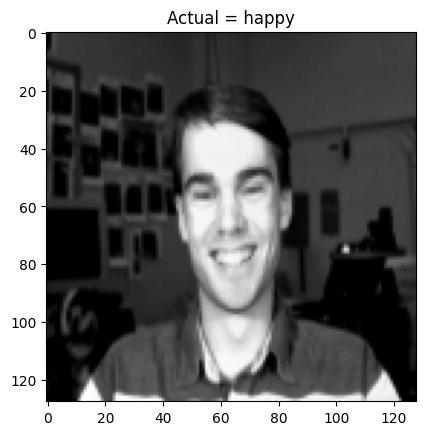

yhat: happy
probability of class  0.413076251745224


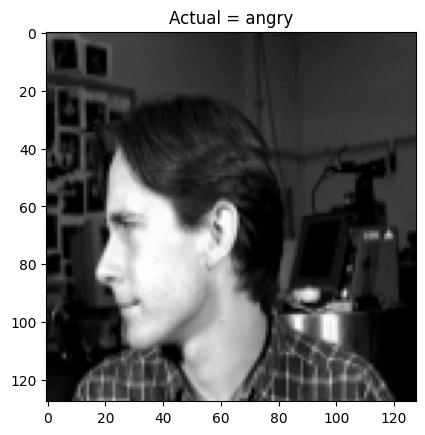

yhat: angry
probability of class  0.42247360944747925


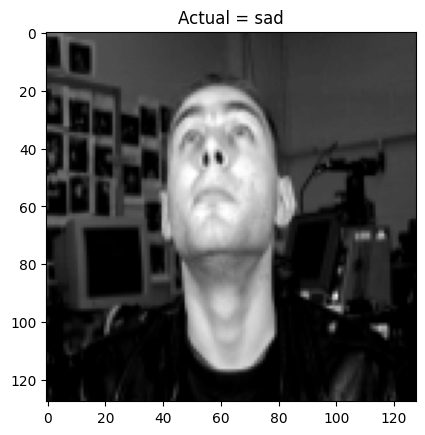

yhat: sad
probability of class  0.29707786440849304


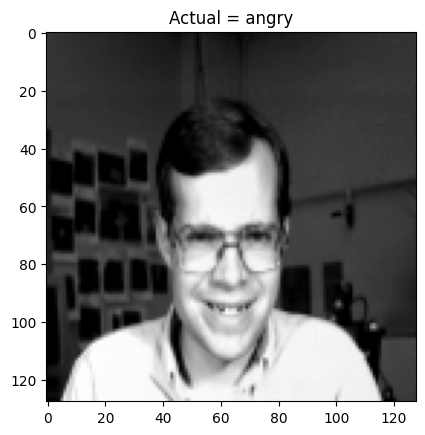

yhat: angry
probability of class  0.46140700578689575


In [26]:
# Plot the misclassified samples
Softmax_fn=nn.Softmax(dim=-1)
count = 0
for x, y in val_dataset:
    z = model(x.unsqueeze(0))
    _, yhat = torch.max(z, 1)
    if yhat == y:
        show_data((x, y))
        plt.show()
        print("yhat:", dataset.classes[yhat])
        print("probability of class ", torch.max(Softmax_fn(z)).item())
        count += 1
    if count >= 50:
        break  

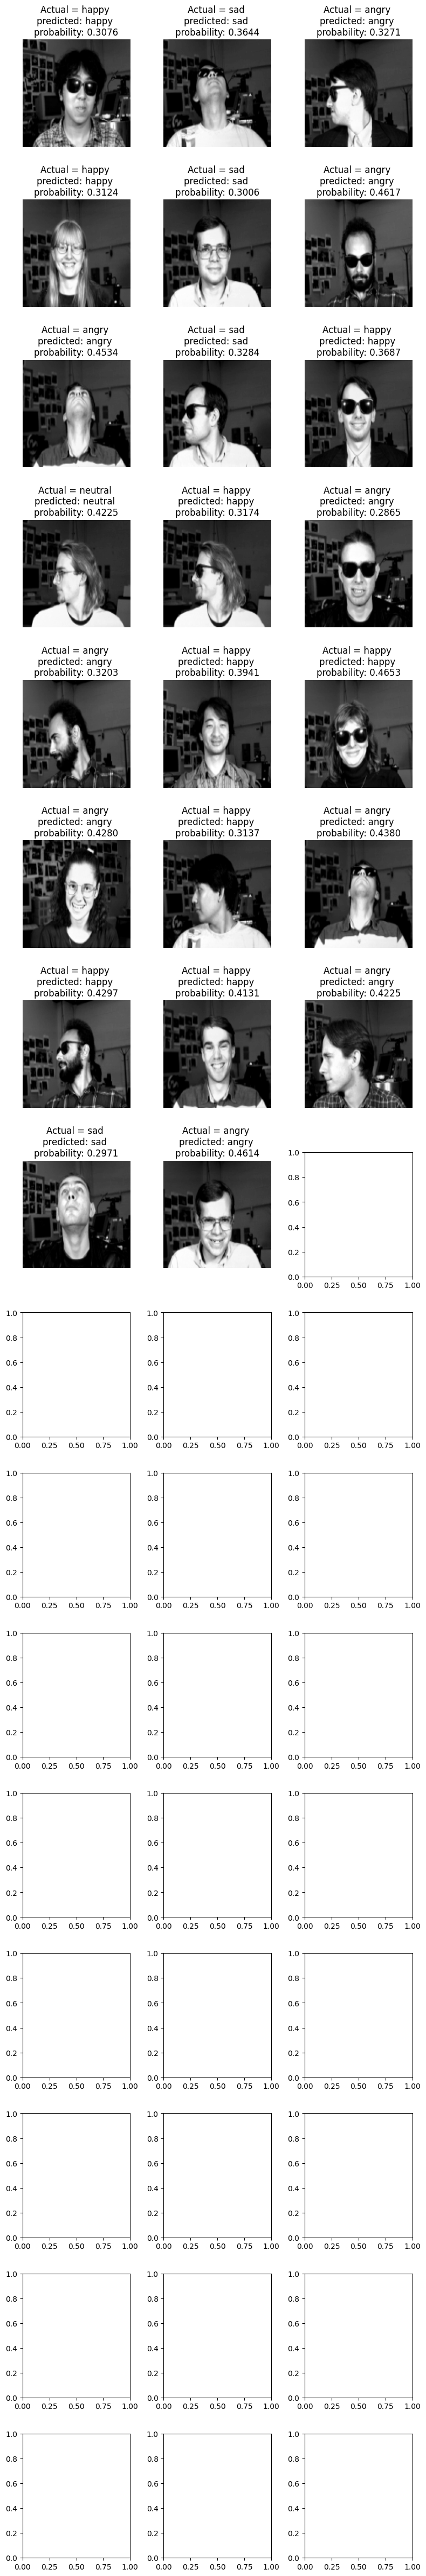

In [27]:
# Softmax function for computing probabilities
Softmax_fn = nn.Softmax(dim=-1)
num_samples_to_plot = 50
fig, axes = plt.subplots(nrows=num_samples_to_plot // 3, ncols=3, figsize=(8, num_samples_to_plot // 3 * 3))
count = 0
for i, (x, y) in enumerate(val_dataset):
    z = model(x.unsqueeze(0))
    _, yhat = torch.max(z, 1)
    if yhat == y:
        ax = axes[count // 3, count % 3]  # Get the correct subplot
        ax.imshow(x.numpy().squeeze(), cmap='gray')  # Assuming grayscale images
        ax.axis('off')  # Hide axis
        ax.set_title(f"Actual = {dataset.classes[y]} \npredicted: {dataset.classes[yhat]} \nprobability: {torch.max(Softmax_fn(z)).item():.4f}")
        count += 1
        if count >= num_samples_to_plot:
            break
plt.tight_layout()
plt.show()

In [28]:

# Print the accuracy for each class
for i, accuracy in accuracy_per_class:
    print(f'Accuracy for class {i} ({dataset.classes[i]}): {accuracy:.2f}%')

NameError: name 'accuracy_per_class' is not defined

In [29]:
# Example usage
num_classes = 4  # Change to the actual number of classes in your dataset
class_accuracies = compute_class_accuracy(model, validation_loader, num_classes)

# Print the accuracy for each class
for i, accuracy in enumerate(class_accuracies):
    print(f'Accuracy for label {i} ({dataset.classes[i]}): {accuracy:.2f}%')

NameError: name 'compute_class_accuracy' is not defined

In [30]:
# Step 4: Train the Model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 10

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()  # Zero the parameter gradients

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects.double() / len(train_dataset)

    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')

    # Validation loop
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    val_corrects = 0

    with torch.no_grad():
        for inputs, labels in validation_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Statistics
            val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            val_corrects += torch.sum(preds == labels.data)

    val_loss /= len(val_dataset)
    val_acc = val_corrects.double() / len(val_dataset)

    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')

print("Training complete!")

Epoch 1/10, Loss: 0.9433, Accuracy: 0.8477
Validation Loss: 1.4811, Validation Accuracy: 0.1920
Epoch 2/10, Loss: 0.9393, Accuracy: 0.8577
Validation Loss: 1.4818, Validation Accuracy: 0.1680
Epoch 3/10, Loss: 0.9286, Accuracy: 0.8557
Validation Loss: 1.4847, Validation Accuracy: 0.1680
Epoch 4/10, Loss: 0.9227, Accuracy: 0.8697
Validation Loss: 1.4791, Validation Accuracy: 0.1920
Epoch 5/10, Loss: 0.9188, Accuracy: 0.8637
Validation Loss: 1.4816, Validation Accuracy: 0.1760
Epoch 6/10, Loss: 0.9159, Accuracy: 0.8677
Validation Loss: 1.4733, Validation Accuracy: 0.2000
Epoch 7/10, Loss: 0.9027, Accuracy: 0.8737
Validation Loss: 1.4792, Validation Accuracy: 0.1760
Epoch 8/10, Loss: 0.9023, Accuracy: 0.8798
Validation Loss: 1.4787, Validation Accuracy: 0.1760
Epoch 9/10, Loss: 0.8979, Accuracy: 0.8838
Validation Loss: 1.4771, Validation Accuracy: 0.1840
Epoch 10/10, Loss: 0.8955, Accuracy: 0.8818
Validation Loss: 1.4833, Validation Accuracy: 0.1680
Training complete!
